In [1]:
from __future__ import print_function
from __future__ import division
from future import standard_library
import sys
import os
import wget
import re
from ufal.udpipe import Model, Pipeline

In [2]:
import os
import string
import tempfile
import tensorflow as tf
import numpy as np

from tensorflow.python.keras.preprocessing import sequence
from tensorboard import summary as summary_lib
from sklearn.model_selection import train_test_split

tf.logging.set_verbosity(tf.logging.INFO)
print(tf.__version__)

D:\anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


1.10.0


In [3]:
import pandas as pd
import numpy as np
from tqdm import tqdm

In [4]:
from utils.preprocessing import *
#from utils.triplet_loss import *
#from utils.model import *

### Подгружаем библиотке для разметки по частям речи при помощи UDPipe

In [5]:
standard_library.install_aliases()

# URL of the UDPipe model
udpipe_model_url = 'https://rusvectores.org/static/models/udpipe_syntagrus.model'
udpipe_filename = udpipe_model_url.split('/')[-1]

if not os.path.isfile(udpipe_filename):
    print('UDPipe model not found. Downloading...')
    wget.download(udpipe_model_url)

print('\nLoading the model...')
model = Model.load(udpipe_filename)
process_pipeline = Pipeline(model, 'tokenize', Pipeline.DEFAULT, Pipeline.DEFAULT, 'conllu')

print('\nModel loaded successfully')


Loading the model...

Model loaded successfully


In [6]:
data = pd.read_pickle('data/banki_ru/sberbank/replies.pkl')
data.head()

,author,bank,bank_response,comment_page,comments_n,rating,text,time,title,mark
276,ShkolinaElena,sberbank,None,1,0,оценка: 1 проверяется,Снимал деньги в банкомате 20.03.2017 в...,07.04.2017 0:36,Не исправно работающие банкоматы проблема банка,1
280,yanamalkova94,sberbank,None,1,0,оценка: 1 проверяется,06.04.2017г. в 22:55 (дата указана на чеке) мн...,06.04.2017 23:12,"Банкомат забрал деньги и выдал ""аварийный чек""",1
281,Nataliivanova,sberbank,None,1,0,оценка: 1 проверяется,Я являюсь поручителем по просроченному кредиту...,06.04.2017 22:01,Политика только Калужского отделения банка?,1
282,nastenka.eroha,sberbank,None,1,0,оценка: 1 проверяется,6 апреля 2017года обратилась в отделение №5221...,06.04.2017 21:47,Некомпетентность сотрудников!,1
287,sparkimus,sberbank,None,1,0,оценка: 3 проверяется,Добрый день!Меня зовут Ольга Александровна(Шве...,06.04.2017 21:42,Сколько можно ждать???!!!,3


In [7]:
txt = [title for title in data['title']]
del data

txt[:5]

['Не исправно работающие банкоматы проблема банка',
 'Банкомат забрал деньги и выдал "аварийный чек"',
 'Политика только Калужского отделения банка?',
 'Некомпетентность сотрудников!',
 'Сколько можно ждать???!!!']

### Подгружаем предобученную w2v модель, производим лемматизация и векторизацию

In [8]:
import io
import zipfile
import pathlib
import urllib.request

WORD2VEC_PATH = pathlib.Path('w2v_model/model.bin')

if not WORD2VEC_PATH.exists():
    print('Downloading model...')
    model_url = 'http://vectors.nlpl.eu/repository/11/180.zip'
    m = wget.download(model_url)
    model_file = model_url.split('/')[-1]
    with zipfile.ZipFile(model_file, 'r') as archive:
        archive.extract('model.bin')
        WORD2VEC_PATH = pathlib.Path('model.bin')

In [9]:
# !pip install paramiko
from gensim.models import KeyedVectors

word2vec = KeyedVectors.load_word2vec_format(WORD2VEC_PATH, binary=True)

In [10]:
def text_to_vec(text):
    vector = []
    tmp = process(process_pipeline, text=text)
    for i in tmp:
        if i in word2vec:
            vector.append(word2vec[i])
    return np.mean(vector, axis=0, dtype=np.float32)

In [11]:
txt_w2v = []
for i in tqdm(txt):
    emb = text_to_vec(i).tolist()
    if(type(emb) == list):
        txt_w2v.append(emb)
del txt

  0%|                                                | 0/50044 [00:00<?, ?it/s]D:\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
D:\anaconda3\lib\site-packages\numpy\core\_methods.py:85: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)
100%|███████████████████████████████████| 50044/50044 [04:05<00:00, 203.96it/s]


In [12]:
news = pd.read_csv('data/news.csv')
news.head()

,title,url,text
0,Центробанк сообщил о сбое в системе быстрых пл...,https://lenta.ru/news/2019/04/07/sboy/,В системе быстрых платежей обнаружены техничес...
1,Названы победители Национальной премии бизнес-...,https://lenta.ru/news/2019/04/05/premia/,Лучшие российские специалисты в третий раз ста...
2,России предсказали замедление роста ВВП,https://lenta.ru/news/2019/04/05/gdpdown/,Всемирный банк понизил для России прогноз по р...
3,«Магнит» поборется с российским олигархом за «...,https://lenta.ru/news/2019/04/05/mangit_lenta/,Розничная сеть «Магнит» направила в марте друг...
4,Российские богачи отказались доверить банкам с...,https://lenta.ru/news/2019/04/05/cash_milliona...,В России насчитывается более 163 тысяч миллион...


In [13]:
titles_w2v = []
for title in tqdm(news.loc[:, 'title']):
    emb = text_to_vec(title).tolist()
    if(type(emb) == list):
        titles_w2v.append(emb)
del news

  3%|█                                    | 298/10000 [00:01<00:49, 195.24it/s]D:\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
D:\anaconda3\lib\site-packages\numpy\core\_methods.py:85: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)
100%|███████████████████████████████████| 10000/10000 [01:03<00:00, 124.11it/s]


### Обучаем модели из sklearn по поиску анамалий

In [14]:
from sklearn.covariance import EllipticEnvelope
from sklearn.svm import OneClassSVM
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.decomposition import PCA
from sklearn.metrics import f1_score

import matplotlib.pyplot as plt
%matplotlib inline

import warnings
import time

warnings.filterwarnings('ignore')

D:\anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [15]:
def fitting_algorithms(data):
    anomaly_algorithms = [('Robust covariance', EllipticEnvelope()),
                          ('One-Class SVM', OneClassSVM()),
                          ('Isolation Forest', IsolationForest()),
                          ('Local Outlier Factor', LocalOutlierFactor())]



    for name, algorithm in anomaly_algorithms:
        if name != 'Local Outlier Factor':
            start = time.time()
            algorithm.fit(data)

            print('fitting ' + name + ': ' + '{:.2f}'.format(time.time() - start) + 's')
    
    return anomaly_algorithms

In [16]:
algorithm_name, algorithm = 'Isolation Forest', IsolationForest()
algorithm.fit(txt_w2v)

IsolationForest(bootstrap=False, contamination=0.1, max_features=1.0,
        max_samples='auto', n_estimators=100, n_jobs=1, random_state=None,
        verbose=0)

### Понижаем размерность для визуализации

In [17]:
# понижаем размерность до 2d
pca_2d = PCA(n_components=2)
pca_2d.fit(txt_w2v + titles_w2v)
txt_dcmp_2d = pca_2d.transform(txt_w2v)
titles_dcmp_2d = pca_2d.transform(titles_w2v)

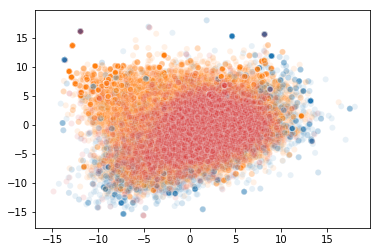

In [18]:
pred = algorithm.predict(txt_w2v)

plt.scatter(txt_dcmp_2d[:, 0], txt_dcmp_2d[:, 1],
            color=['tab:orange' if l == 1 else 'tab:blue' for l in pred],
            edgecolors='w', alpha=0.1)

plt.scatter(titles_dcmp_2d[:, 0], titles_dcmp_2d[:, 1],
                  color='tab:red', edgecolors='w', alpha=0.1)

plt.show()

### Посчитаем качество

In [19]:
X, Y = [], []
for i in txt_w2v:
    X.append(i)
    Y.append(1)
    
for i in titles_w2v:
    X.append(i)
    Y.append(0)

x_train_variable, x_test_variable, y_train, y_test = train_test_split(X, Y, test_size = 0.15)

In [20]:
pred = algorithm.predict(x_test_variable)
y_pred = [1 if i == 1 else 0 for i in pred]

print(algorithm_name + ' | F1 score: {:.5f}'.format(f1_score(y_test, y_pred)))

Isolation Forest | F1 score: 0.85942


### Полученный результат говорит о том, что алгоритм Isolation Forest хорошо кластеризовал заголовки с банки.ру. Теперь попробуем сильнее разнести вектора заголовков в пространстве. Это должно увеличить точность предсказаний. Для этого обучим небольшую нейросеть с триплет лосом.

In [21]:
# Добавим в аномалии текст не связанный с банковской тематикой. Например, Маяковского. (⊙_⊙)
file = open(file='data/Mayakovsky.txt', mode='r', encoding='latin1')
anom = [paragraph.encode('latin1').decode('cp1251') for paragraph in file]
file.close()

for line in anom[13:18]:
    print(line)

Вашу мысль,

мечтающую на размягченном мозгу,

как выжиревший лакей на засаленной кушетке,

буду дразнить об окровавленный сердца лоскут:

досыта изъиздеваюсь, нахальный и едкий.



In [22]:
anom_w2v = []
for i in tqdm(anom):
    emb = text_to_vec(i).tolist()
    if(type(emb) == list):
        anom_w2v.append(emb)
del anom

100%|███████████████████████████████████| 61104/61104 [02:07<00:00, 480.29it/s]


### Подготовка данных и обучение модели с триплет лосом, для лучшей кластеризации заголовков с банки.ру

In [23]:
X, Y = [], []
for i in txt_w2v:
    X.append(i)
    Y.append(1)
    
for i in titles_w2v + anom_w2v:
    X.append(i)
    Y.append(0)

In [24]:
x_train_variable, x_test_variable, y_train, y_test = train_test_split(X, Y, test_size = 0.15)

In [25]:
def parser(x, y):
    features = {"x": x}
    return features, y

def parser_p(x):
    features = {"x": x}
    return features

def train_input_fn():
    dataset = tf.data.Dataset.from_tensor_slices((x_train_variable, y_train))
    dataset = dataset.shuffle(buffer_size=len(x_train_variable))
    dataset = dataset.batch(100)
    dataset = dataset.map(parser)
    dataset = dataset.repeat()
    iterator = dataset.make_one_shot_iterator()
    return iterator.get_next()

def eval_input_fn():
    dataset = tf.data.Dataset.from_tensor_slices((x_test_variable, y_test))
    dataset = dataset.batch(100)
    dataset = dataset.map(parser)
    iterator = dataset.make_one_shot_iterator()
    return iterator.get_next()

def pred_input_fn():
    dataset = tf.data.Dataset.from_tensor_slices((X_p))
    dataset = dataset.batch(100)
    dataset = dataset.map(parser_p)
    iterator = dataset.make_one_shot_iterator()
    return iterator.get_next()

In [26]:
def _pairwise_distances(embeddings, squared=False):

    dot_product = tf.matmul(embeddings, tf.transpose(embeddings))


    square_norm = tf.diag_part(dot_product)


    distances = tf.expand_dims(square_norm, 1) - 2.0 * dot_product + tf.expand_dims(square_norm, 0)

    distances = tf.maximum(distances, 0.0)

    if not squared:

        mask = tf.to_float(tf.equal(distances, 0.0))
        distances = distances + mask * 1e-16

        distances = tf.sqrt(distances)

        distances = distances * (1.0 - mask)

    return distances


def _get_anchor_positive_triplet_mask(labels):

    indices_equal = tf.cast(tf.eye(tf.shape(labels)[0]), tf.bool)
    indices_not_equal = tf.logical_not(indices_equal)

 
    labels_equal = tf.equal(tf.expand_dims(labels, 0), tf.expand_dims(labels, 1))

    mask = tf.logical_and(indices_not_equal, labels_equal)

    return mask


def _get_anchor_negative_triplet_mask(labels):

    labels_equal = tf.equal(tf.expand_dims(labels, 0), tf.expand_dims(labels, 1))

    mask = tf.logical_not(labels_equal)

    return mask


def _get_triplet_mask(labels):

    indices_equal = tf.cast(tf.eye(tf.shape(labels)[0]), tf.bool)
    indices_not_equal = tf.logical_not(indices_equal)
    i_not_equal_j = tf.expand_dims(indices_not_equal, 2)
    i_not_equal_k = tf.expand_dims(indices_not_equal, 1)
    j_not_equal_k = tf.expand_dims(indices_not_equal, 0)

    distinct_indices = tf.logical_and(tf.logical_and(i_not_equal_j, i_not_equal_k), j_not_equal_k)


    label_equal = tf.equal(tf.expand_dims(labels, 0), tf.expand_dims(labels, 1))
    i_equal_j = tf.expand_dims(label_equal, 2)
    i_equal_k = tf.expand_dims(label_equal, 1)

    valid_labels = tf.logical_and(i_equal_j, tf.logical_not(i_equal_k))

    mask = tf.logical_and(distinct_indices, valid_labels)

    return mask


def batch_all_triplet_loss(labels, embeddings, margin, squared=False):

    pairwise_dist = _pairwise_distances(embeddings, squared=squared)

    anchor_positive_dist = tf.expand_dims(pairwise_dist, 2)
    assert anchor_positive_dist.shape[2] == 1, "{}".format(anchor_positive_dist.shape)
    anchor_negative_dist = tf.expand_dims(pairwise_dist, 1)
    assert anchor_negative_dist.shape[1] == 1, "{}".format(anchor_negative_dist.shape)

    triplet_loss = anchor_positive_dist - anchor_negative_dist + margin


    mask = _get_triplet_mask(labels)
    mask = tf.to_float(mask)
    triplet_loss = tf.multiply(mask, triplet_loss)

    triplet_loss = tf.maximum(triplet_loss, 0.0)

    valid_triplets = tf.to_float(tf.greater(triplet_loss, 1e-16))
    num_positive_triplets = tf.reduce_sum(valid_triplets)
    num_valid_triplets = tf.reduce_sum(mask)
    fraction_positive_triplets = num_positive_triplets / (num_valid_triplets + 1e-16)

    triplet_loss = tf.reduce_sum(triplet_loss) / (num_positive_triplets + 1e-16)

    return triplet_loss, fraction_positive_triplets


def batch_hard_triplet_loss(labels, embeddings, margin, squared=False):

    pairwise_dist = _pairwise_distances(embeddings, squared=squared)


    mask_anchor_positive = _get_anchor_positive_triplet_mask(labels)
    mask_anchor_positive = tf.to_float(mask_anchor_positive)

    anchor_positive_dist = tf.multiply(mask_anchor_positive, pairwise_dist)

    hardest_positive_dist = tf.reduce_max(anchor_positive_dist, axis=1, keepdims=True)
    tf.summary.scalar("hardest_positive_dist", tf.reduce_mean(hardest_positive_dist))

    mask_anchor_negative = _get_anchor_negative_triplet_mask(labels)
    mask_anchor_negative = tf.to_float(mask_anchor_negative)

    max_anchor_negative_dist = tf.reduce_max(pairwise_dist, axis=1, keepdims=True)
    anchor_negative_dist = pairwise_dist + max_anchor_negative_dist * (1.0 - mask_anchor_negative)

    hardest_negative_dist = tf.reduce_min(anchor_negative_dist, axis=1, keepdims=True)
    tf.summary.scalar("hardest_negative_dist", tf.reduce_mean(hardest_negative_dist))

    triplet_loss = tf.maximum(hardest_positive_dist - hardest_negative_dist + margin, 0.0)

    triplet_loss = tf.reduce_mean(triplet_loss)

    return triplet_loss

In [37]:
def model_custom(features, labels, mode, params):

    inputs = tf.layers.dense(inputs=features['x'], units=150, activation=tf.nn.relu)

    
    embeddings = tf.layers.dense(inputs=inputs, units=50)
    
    embedding_mean_norm = tf.reduce_mean(tf.norm(embeddings, axis=1))
    tf.summary.scalar("embedding_mean_norm", embedding_mean_norm)

    if mode == tf.estimator.ModeKeys.PREDICT:
        predictions = {'embeddings': embeddings}
        return tf.estimator.EstimatorSpec(mode=mode, predictions=predictions)

    labels = tf.cast(labels, tf.int64)

    loss = batch_hard_triplet_loss(labels, embeddings, margin=0.5, squared=False)


 
    with tf.variable_scope("metrics"):
        eval_metric_ops = {"embedding_mean_norm": tf.metrics.mean(embedding_mean_norm)}



    if mode == tf.estimator.ModeKeys.EVAL:
        return tf.estimator.EstimatorSpec(mode, loss=loss, eval_metric_ops=eval_metric_ops)


    tf.summary.scalar('loss', loss)



    optimizer = tf.train.AdamOptimizer(learning_rate=0.0003)
    global_step = tf.train.get_global_step()

    train_op = optimizer.minimize(loss, global_step=global_step)

    return tf.estimator.EstimatorSpec(mode, loss=loss, train_op=train_op)


In [38]:
config = tf.estimator.RunConfig(tf_random_seed=123,
                                save_checkpoints_steps=500,
                                model_dir='new',
                                save_summary_steps=20)
classifier = tf.estimator.Estimator(model_fn=model_custom,
                                         config=config)

tf.estimator.train_and_evaluate(
    classifier,
    train_spec=tf.estimator.TrainSpec(input_fn=train_input_fn, max_steps = 8000),
    eval_spec=tf.estimator.EvalSpec(input_fn= eval_input_fn, steps = None, start_delay_secs=0, throttle_secs=60)
)

INFO:tensorflow:Using config: {'_model_dir': 'new', '_tf_random_seed': 123, '_save_summary_steps': 20, '_save_checkpoints_steps': 500, '_save_checkpoints_secs': None, '_session_config': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x000000DBDC8A6BA8>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
INFO:tensorflow:Running training and evaluation locally (non-distributed).
INFO:tensorflow:Start train and evaluate loop. The evaluate will happen after every checkpoint. Checkpoint frequency is determined based on RunConfig arguments: save_checkpoints_steps 500 or save_checkpoints_secs None.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
IN

INFO:tensorflow:loss = 0.81032354, step = 4600 (0.660 sec)
INFO:tensorflow:global_step/sec: 156.139
INFO:tensorflow:loss = 0.8055075, step = 4700 (0.640 sec)
INFO:tensorflow:global_step/sec: 153.03
INFO:tensorflow:loss = 0.80146325, step = 4800 (0.654 sec)
INFO:tensorflow:global_step/sec: 151.178
INFO:tensorflow:loss = 0.78381515, step = 4900 (0.661 sec)
INFO:tensorflow:Saving checkpoints for 5000 into new\model.ckpt.
INFO:tensorflow:Skip the current checkpoint eval due to throttle secs (60 secs).
INFO:tensorflow:global_step/sec: 28.1529
INFO:tensorflow:loss = 0.78900456, step = 5000 (3.552 sec)
INFO:tensorflow:global_step/sec: 129.608
INFO:tensorflow:loss = 0.7279715, step = 5100 (0.772 sec)
INFO:tensorflow:global_step/sec: 153.032
INFO:tensorflow:loss = 0.7215067, step = 5200 (0.653 sec)
INFO:tensorflow:global_step/sec: 156.383
INFO:tensorflow:loss = 0.70810694, step = 5300 (0.639 sec)
INFO:tensorflow:global_step/sec: 154.928
INFO:tensorflow:loss = 0.7066757, step = 5400 (0.644 sec)


({'embedding_mean_norm': 0.095918514, 'global_step': 8000, 'loss': 0.5409101},
 [])

### Проганяем данные через обученную модель

In [39]:
X_p = txt_w2v
txt_em, txt_em_norm = [], []
prediction = classifier.predict(pred_input_fn)
for i in range(len(X_p)):
    txt_em.append(next(prediction))

for i in range(len(X_p)):
    txt_em_norm.append(txt_em[i]['embeddings'])

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from new\model.ckpt-8000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


In [40]:
X_p = titles_w2v
titles_em, titles_em_norm = [], []
prediction = classifier.predict(pred_input_fn)
for i in range(len(X_p)):
    titles_em.append(next(prediction))

for i in range(len(X_p)):
    titles_em_norm.append(titles_em[i]['embeddings'])

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from new\model.ckpt-8000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


In [41]:
X_p = anom_w2v
anom_em, anom_em_norm = [], []
prediction = classifier.predict(pred_input_fn)
for i in range(len(X_p)):
    anom_em.append(next(prediction))

for i in range(len(X_p)):
    anom_em_norm.append(anom_em[i]['embeddings'])

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from new\model.ckpt-8000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


### Обучаем модели из sklearn по поиску анамалий на векторах, которые мы получили

In [42]:
anomaly_algorithms = fitting_algorithms(txt_em_norm)

fitting Robust covariance: 62.34s
fitting One-Class SVM: 299.19s
fitting Isolation Forest: 5.07s


### Понижаем размерность для визуализации

In [43]:
# понижаем размерность до 2d
pca_2d = PCA(n_components=2)
pca_2d.fit(txt_em_norm + titles_em_norm + anom_em_norm)
txt_dcmp_2d = pca_2d.transform(txt_em_norm)
titles_dcmp_2d = pca_2d.transform(titles_em_norm)
anom_dcmp_2d = pca_2d.transform(anom_em_norm)

# понижаем размерность до 3d
pca_3d = PCA(n_components=3)
pca_3d.fit(txt_em_norm + titles_em_norm + anom_em_norm)
txt_dcmp_3d = pca_3d.transform(txt_em_norm)
titles_dcmp_3d = pca_3d.transform(titles_em_norm)
anom_dcmp_3d = pca_3d.transform(anom_em_norm)

Robust covariance preparing...
One-Class SVM preparing...
Isolation Forest preparing...
Local Outlier Factor preparing...


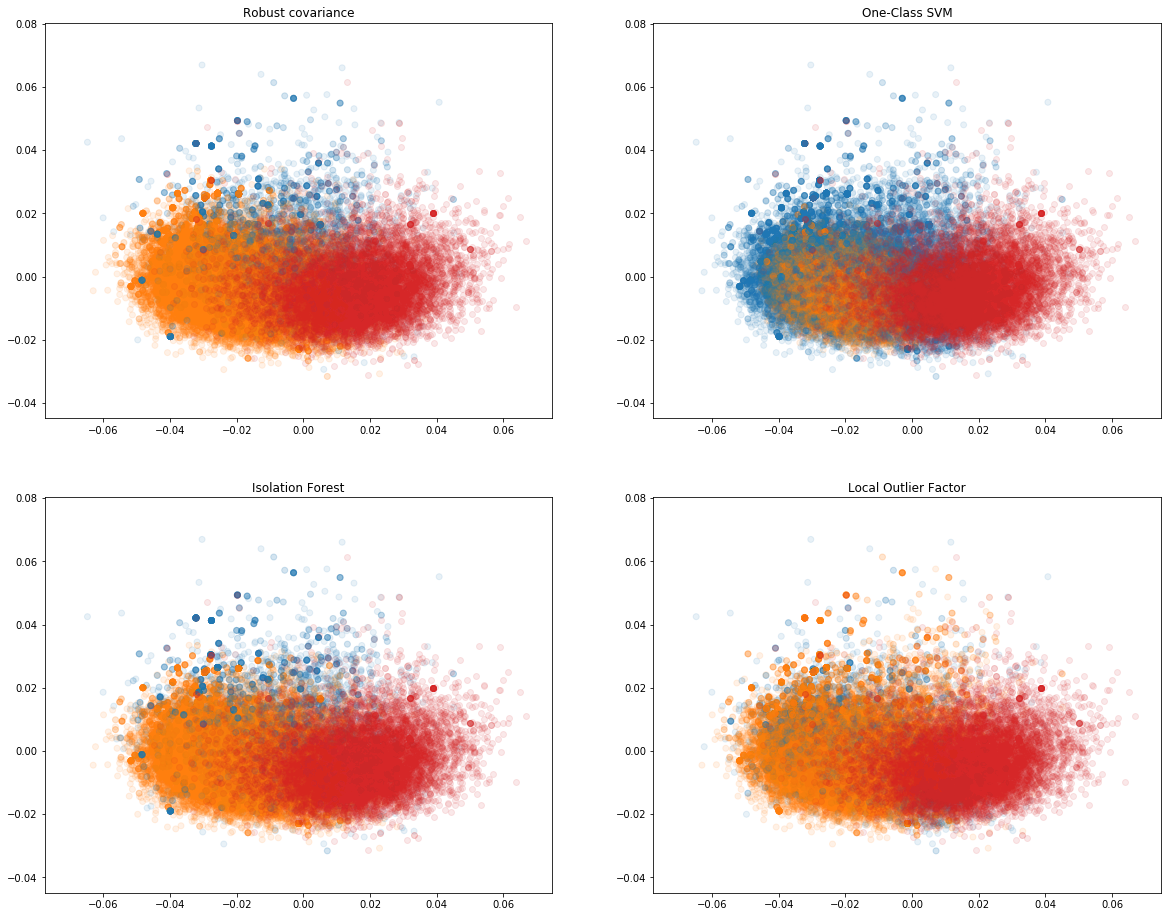

In [44]:
fig, axs = plt.subplots(2, 2, figsize=(20, 16))

n, i, j = 0, 0, 0
for name, algorithm in anomaly_algorithms:
    axs[i, j].set(title=name)
    print(name + ' preparing...')
    
    if name != "Local Outlier Factor":
        pred = algorithm.predict(txt_em_norm)
    else:
        pred = algorithm.fit_predict(txt_em_norm)
        
    axs[i, j].scatter(txt_dcmp_2d[:, 0], txt_dcmp_2d[:, 1],
                      color=['tab:orange' if l == 1 else 'tab:blue' for l in pred],
                      alpha=0.1)
    
    axs[i, j].scatter(titles_dcmp_2d[:, 0], titles_dcmp_2d[:, 1],
                      color='tab:red', alpha=0.1)
    
    n += 1
    i, j = n // 2, n % 2

plt.show()

In [45]:
X_p = x_test_variable
test_em, test_em_norm = [], []
prediction = classifier.predict(pred_input_fn)
for i in range(len(X_p)):
    test_em.append(next(prediction))

for i in range(len(X_p)):
    test_em_norm.append(test_em[i]['embeddings'])

for name, algorithm in anomaly_algorithms:
    if name != "Local Outlier Factor":
        pred = algorithm.predict(test_em_norm)
        y_pred = [1 if i == 1 else 0 for i in pred]

        print(name + ' | F1 score: {:.5f}'.format(f1_score(y_test, y_pred)))

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from new\model.ckpt-8000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Robust covariance | F1 score: 0.74909
One-Class SVM | F1 score: 0.64882
Isolation Forest | F1 score: 0.74325


### Предсказания сделаные на векторах после пропуска через нейросеть показали меньший скор, следовательно стоит дообучить сеть или попробовать альтернативные архитектуры и алгоритмы для лучшей кластаризации данных